# Facts about countries - Using Python With SQLite

In this project I querry a SQLite database using python. SQLite is a relational database management system that enables us to create databases and query them using SQL syntax. SQLite is simpler than full database systems like MySQL and PostgreSQL likely at the expense of reduced performance. The sqlite3 library comes with Python by default allows us to connect to SQLite databases and do a variety of things with it. For instance, the entire SQLite databases can be imported as a pandas dataframe.

## Overview of the Dataset
I am working on CIA World Factbook converted to a SQLite database. This database contains demographic information for each country in the world. Some of the columns in the dataset are:

* population - The population as of 2015
* population_growth - The annual population growth rate, as a percentage
* area - The total land and water area
You can download the Factbook as a SQLite database from [GitHub here](https://github.com/factbook/factbook.sql). You can also look at this guided project by [DataQuest](https://www.dataquest.io/mission/156/guided-project-working-with-a-sqlite-database).

We can open the Factbook database in the SQLite Command Shell by navigating to the same folder as factbook.db, then typing sqlite3 factbook.db. We can then use the .tables command to see the tables lying in this dataset. This SQLite database only contains a single table called facts.

In [1]:
# Import relevant libraries
import sqlite3
import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 16})

## Connect with Dataset & Query

The sqlite3 module was written by Gerhard Häring. It provides a SQL interface with python. To use the module, we need the following steps:
- Create a Connection object that represents the database. For example, following code will let us connect to factbook.db with variable _myConnection_
- Once we have a Connection, we can create a Cursor object, _myCursor_ and call its execute() method to perform SQL commands
- Specify a SQL query, _muQuery_ in the execute method. For example, I have selected 10 rows for the columns, 'name', 'population', 'area', from the dataset ordered by population.
- Fetch the results using the fetchall method, notice that the result is stored as list of tuples and not list of lists, to reduce the computational time.
- Close the connection if done.

You will notice that we can specify any SQL query and get the results that we want. So it's already very powerful. I like to import the database into a pandas dataframe to play around with the data more, specially when the dataset is not too big. 

In [2]:
# Create a connection instance
myConnection = sqlite3.connect('factbook.db')

# create a Cursor object
myCursor = myConnection.cursor()

# Store the query as string
myQuery = 'SELECT name, population, area FROM facts ORDER BY population DESC LIMIT 10;'

# Query the dataset
myCursor.execute(myQuery)

# Fetch the results 
Large_countries = myCursor.execute(myQuery).fetchall()
print(Large_countries)

# Close the connection
myConnection.close()

[('World', 7256490011, None), ('China', 1367485388, 9596960), ('India', 1251695584, 3287263), ('European Union', 513949445, 4324782), ('United States', 321368864, 9826675), ('Indonesia', 255993674, 1904569), ('Brazil', 204259812, 8515770), ('Pakistan', 199085847, 796095), ('Nigeria', 181562056, 923768), ('Bangladesh', 168957745, 148460)]


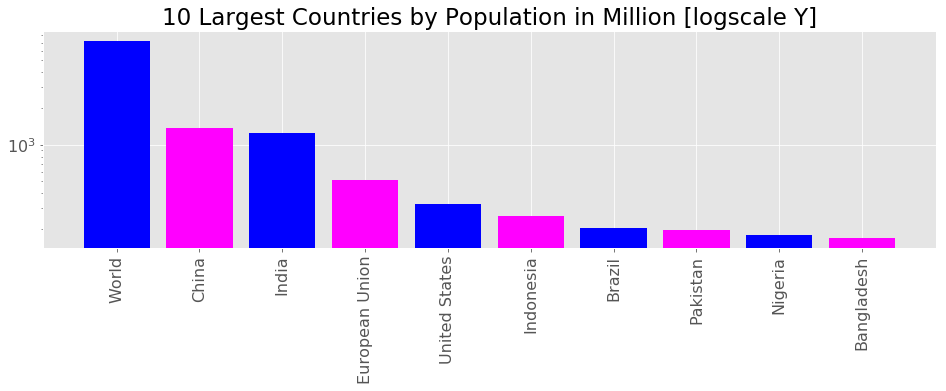

In [3]:
# Play around with the imported Query results
plt.figure(figsize=(16,4))
x_labels = [x[0] for x in Large_countries]
y_val = [x[1]/10**6 for x in Large_countries]
x_val = range(0,len(y_val))
plt.bar(x_val, y_val, color=['blue', 'magenta'])
plt.xticks(x_val, x_labels, rotation='vertical')
plt.yscale('log')
plt.title('10 Largest Countries by Population in Million [logscale Y]')
plt.show()

## Read Results of a SQL Query into a pandas Dataframe

We can read the results of a SQL query into a pandas dataframe using the read_sql_query function.

- The read_sql_query function takes a SQL query string and a connection object, and returns a dataframe containing all of the rows and columns from the query.

- pandas automatically takes the column types and names from the original the database and converts blank entries in the database to NaN values. 

In [4]:
# Create a connection instance
myConnection = sqlite3.connect('factbook.db')

# Store the query as string
# Select everything from the dataset
myQuery = 'SELECT * FROM facts ORDER BY population;'

# Create a dataframe using query and myConnection
df = pd.read_sql_query(myQuery, myConnection)

# Check the dataframe
print(df.columns)
print(df.shape)
print(df.info())

Index(['id', 'code', 'name', 'area', 'area_land', 'area_water', 'population',
       'population_growth', 'birth_rate', 'death_rate', 'migration_rate',
       'created_at', 'updated_at'],
      dtype='object')
(261, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 13 columns):
id                   261 non-null int64
code                 261 non-null object
name                 261 non-null object
area                 249 non-null float64
area_land            246 non-null float64
area_water           243 non-null float64
population           242 non-null float64
population_growth    236 non-null float64
birth_rate           228 non-null float64
death_rate           228 non-null float64
migration_rate       223 non-null float64
created_at           261 non-null object
updated_at           261 non-null object
dtypes: float64(8), int64(1), object(4)
memory usage: 26.6+ KB
None


## Perform Analysis on Dataframe

Here I read the facts table into pandas, and then compute the projected population for each country in 2050 using the following steps:

- The annual population growth (expressed as a percentage) for each country is in the population_growth column, while the initial population for 2015 is in the population column.
- Drop any rows/contries that don't have data for population and population_growth.
- Write a function that takes in a country's initial population and growth rate, and then outputs the final population.
- The formula for compound annual population growth is: $$N = A e^{r t}$$ N is the final population, A is the initial population r is the rate of annual change and t is the number of years we want to project out.

- Use the apply method on pandas dataframes to compute what the population will be in 2050 for each row in the data. 
- Use the dataframe sort_values method to sort on the 2050 population in descending order.
- Print the 10 countries that will have the highest populations in 2050.
- Print countries that have largest change in populations

In [5]:
# Drop rows with null population_growth and popolation
df = df.dropna(subset= ['population_growth', 'population'])
print(df.shape)

# Function to calculate population in 2050
def predict_population(row):
    yrs_out = 35
    A = float(row['population'])
    x = float(row['population_growth']/100)
    N =  A * math.e** (x*yrs_out)
    return (round(N,0))
    
# Create a column in the dataframe
# With 2050 population
df['population_2050'] = df.apply(predict_population, axis=1)

# Sort values by population_2050
df_by_population = df.sort_values('population_2050', ascending = False, inplace=False).head(20)
print(df_by_population[['name', 'population','population_2050']].head(5))


(236, 13)
               name    population  population_2050
260           World  7.256490e+09     1.058985e+10
258           India  1.251696e+09     1.918415e+09
259           China  1.367485e+09     1.600752e+09
257  European Union  5.139494e+08     5.609461e+08
252         Nigeria  1.815621e+08     4.279890e+08


In [6]:
# Largest Positive change in population
df['population_chng'] = df['population_2050'] - df['population']

df_positive_chng = df.sort_values('population_chng', ascending = False, inplace=False).head(20)
print(df_positive_chng[['name', 'population','population_2050', 'population_chng']].head(5))

         name    population  population_2050  population_chng
260     World  7.256490e+09     1.058985e+10     3.333363e+09
258     India  1.251696e+09     1.918415e+09     6.667190e+08
252   Nigeria  1.815621e+08     4.279890e+08     2.464269e+08
259     China  1.367485e+09     1.600752e+09     2.332667e+08
246  Ethiopia  9.946582e+07     2.735034e+08     1.740376e+08


As you can see, if the population grows with the compounded growth rate, India will overtake China to be the largest country in terms of population. Nigeria follows India to achieve largest gains in population. 